In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## define PSF

In [2]:
def R_lambda(q_obs, q_mod, lambda_ratio_list, w_lambda, mu_q):
    r"""
    Constructs the full polychromatic point-spread function R(q, q') such that

        I_obs(q) = ∫ R(q, q') I_mod(q') dq'  ≈  (R @ I_mod)(q)

    Parameters
    ----------
    q_obs : (M_obs,) ndarray
        Q-values where the observed intensity I_obs(q) is evaluated.
    q_mod : (M_mod,) ndarray
        Q'-values defining the latent/model intensity I_mod(q').
    lambda_ratio_list : (N,) ndarray
        Ratios ρ_i = λ_i / λ_0 for each wavelength component.
    w_lambda : (N,) ndarray
        Normalized spectral weights (∑ w_lambda = 1).
    mu_q : float
        Gaussian width (in Q-units) controlling the mapping spread from q_mod → q_obs.

        - Small mu_q  → narrow PSF, nearly δ(q−ρq′)
        - Large mu_q  → broad smearing, stronger convolution

    Returns
    -------
    R : (M_obs, M_mod) ndarray
        Discrete kernel approximating R(q, q') including wavelength distribution.

    Notes
    -----
    Implements:
        R(q,q') = Σ_i w_i · [ exp(−(q − ρ_i q')² / (2 μ_q²)) / Z_i(q') ]
    where Z_i(q') ensures ∫ R(q,q') dq = 1 for each q'.

    --------------------------------------------------------------------------
    LaTeX source 
    --------------------------------------------------------------------------
    \begin{equation}
        R(q,q')
        \;=\;
        \sum_{i} w_i \,
        \frac{
            \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        }{
            Z_i(q')
        },
        \qquad
        Z_i(q')
        \;=\;
        \int_{-\infty}^{\infty}
        \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        \mathrm{d}q.
        \label{eq:R_q_def}
    \end{equation}
    --------------------------------------------------------------------------
    """
    q_obs = np.asarray(q_obs)
    q_mod = np.asarray(q_mod)
    lambda_ratio_list = np.asarray(lambda_ratio_list)
    w_lambda = np.asarray(w_lambda)

    M_obs, M_mod = q_obs.size, q_mod.size
    R = np.zeros((M_obs, M_mod), dtype=float)

    # --- Implements: R(q, q') = Σ_i w_i * exp[-(q - ρ_i q')² / (2 μ_q²)] / Z_i(q') ---
    for rho, w_i in zip(lambda_ratio_list, w_lambda):
        q_center = rho * q_mod[None, :]           # Shift q' → ρ_i q'
        diff = q_obs[:, None] - q_center          # (M_obs, M_mod)
        phi = np.exp(-0.5 * (diff / mu_q) ** 2)

        # Normalize over q_obs for each q' (column-wise)
        Z_i = phi.sum(axis=0, keepdims=True)
        Z_i[Z_i == 0] = 1.0
        phi /= Z_i

        # Weighted sum over wavelength components
        R += w_i * phi

    return R

In [3]:
# -----------------------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------------------

def _ensure_1d(a: ArrayLike) -> np.ndarray:
    a = np.asarray(a, dtype=float)
    if a.ndim != 1:
        raise ValueError("Input arrays must be 1D")
    return a


def _gauss_legendre_ab(a: float, b: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Return Gauss–Legendre nodes x and weights w mapped to [a, b]."""
    t, w = np.polynomial.legendre.leggauss(n)
    # map from [-1,1] to [a,b]
    x = 0.5 * (b - a) * t + 0.5 * (a + b)
    w = 0.5 * (b - a) * w
    return x, w


def _gaussian_smoother(Q_mod: np.ndarray, mu_Q: float) -> np.ndarray:
    """Row-normalized Gaussian kernel S over Q_mod with std=mu_Q.

    S has shape (M_mod, M_mod) and rows sum to 1. Applying smoothing to a kernel
    R (M_obs, M_mod) is done as: R_smoothed = R @ S.T
    """
    if mu_Q <= 0:
        return None  # sentinel for no smoothing
    Q = Q_mod[:, None]
    d2 = (Q - Q.T) ** 2
    # Add a tiny epsilon in case mu_Q is extremely small to avoid over/underflow
    eps = 1e-30
    S = np.exp(-0.5 * d2 / max(mu_Q * mu_Q, eps))
    # Row-normalize
    row_sum = S.sum(axis=1, keepdims=True)
    # Avoid division by zero on pathological inputs
    row_sum[row_sum == 0] = 1.0
    S /= row_sum
    return S


def renormalize_rows(R: np.ndarray, Q_mod: np.ndarray) -> np.ndarray:
    """Renormalize rows of R so that \int R(Qx_i, Q') dQ' ≈ 1 numerically.

    Parameters
    ----------
    R : (M_obs, M_mod) array
    Q_mod : (M_mod,) grid for Q'
    """
    Q_mod = _ensure_1d(Q_mod)
    if R.ndim != 2 or R.shape[1] != Q_mod.size:
        raise ValueError("R must be 2D with second dimension equal to len(Q_mod)")
    # Numerical integral over Q'
    integ = np.trapz(R, Q_mod, axis=1)
    # Prevent divide-by-zero; rows with zero integral remain zero
    scale = np.ones_like(integ)
    nz = np.abs(integ) > 0
    scale[nz] = 1.0 / integ[nz]
    return (R.T * scale).T


# -----------------------------------------------------------------------------
# 1) Vertical slit kernel
# -----------------------------------------------------------------------------

def R_slit(Qx_obs: ArrayLike, Q_mod: ArrayLike, sigma_y: float, mu_Q: float = 0.0) -> np.ndarray:
    r"""
    Discrete slit-averaged PSF R_slit(Q_x, Q') for

        I_exp(Q_x) = (1/(2 σ_y)) ∫_{-σ_y}^{σ_y} I( sqrt(Q_x^2 + Q_y^2) ) dQ_y
                    = ∫ R_slit(Q_x, Q') I(Q') dQ'.

    Implements the analytical kernel

        R_slit(Q_x, Q') = { (1/σ_y) * Q' / sqrt(Q'^2 − Q_x^2),
                             if Q_x ≤ Q' ≤ sqrt(Q_x^2 + σ_y^2);
                             0 otherwise }.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Positions where I_exp(Qx) is evaluated (assume Qx_obs > 0).
    Q_mod : (M_mod,) array
        Radial grid Q' where I(Q') is defined.
    sigma_y : float
        Half-width of the vertical slit (in Q_y units).
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive")

    # Broadcasted computation over (M_obs, M_mod)
    Qx_mat = Qx[:, None]      # (M_obs, 1)
    Qp_row = Qp[None, :]      # (1, M_mod)

    # Support and unregularized denom
    support = (Qp_row >= Qx_mat) & (Qp_row <= np.sqrt(Qx_mat**2 + sigma_y**2))

    # Grid-dependent regularization scale for the singularity
    # if Qp.size > 1:
    #     dQ_min = np.min(np.diff(Qp))
    #     eps = 0.5 * dQ_min
    # else:
    #     eps = 1e-12  # fallback if only one point
    eps = 1e-15
    # Regularized denominator: sqrt(Q'^2 - Q_x^2 + eps^2)
    denom_sq = Qp_row**2 - Qx_mat**2
    denom_reg = np.sqrt(np.maximum(denom_sq, 0.0) + eps**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = Qp_row / denom_reg
        base = np.where(support, (1.0 / sigma_y) * ratio, 0.0)

    R = base

    # Optional smoothing along Q' (right-multiply by S^T)
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Renormalize rows to conserve intensity numerically
    # R = renormalize_rows(R, Qp)
    return R

# -----------------------------------------------------------------------------
# 2) Rectangular pinhole: average of slit kernels across Qx' ∈ [Qx-σx, Qx+σx]
# -----------------------------------------------------------------------------

def R_rect(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_x: float,
    sigma_y: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Rectangular pinhole PSF via horizontal averaging of slit PSFs:

        R_rect(Qx, Q') = (1/(2 σ_x)) ∫_{Qx-σ_x}^{Qx+σ_x} R_slit(Qx', Q'; σ_y) dQx'.

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature (default) or by a simple trapezoidal rule over a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_x, Qx+σ_x] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod  : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_x : float
        Horizontal half-width of the rectangle.
    sigma_y : float
        Vertical half-width of the rectangle (slit half-width).
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True, use analytic bin-averaged slit kernel over each Q' bin to avoid
        the integrable singularity at Q' = Qx'. If False, uses pointwise formula.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Rectangular PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_x <= 0 or sigma_y <= 0:
        raise ValueError("sigma_x and sigma_y must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        a, b = qx - sigma_x, qx + sigma_x

        if quad == "gauss":
            # Gauss–Legendre nodes and weights on [a,b]
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # support in Q': [xprime, sqrt(xprime^2 + sigma_y^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    # Intersect each bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk  # non-empty intersection

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # analytic integral over bin, then divide by bin width
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    # Pointwise formula (avoid exact equality to suppress singular samples)
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                accum += w * r_line

            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            # We will build r(x', Q') as a 2D array of shape (nx, M_mod)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# 3) Round pinhole: weighted superposition of slit PSFs with σ_y(Qx')
# -----------------------------------------------------------------------------

def R_pinhole(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_Q: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Round (circular) pinhole PSF via superposition of slit PSFs with
    σ_y(Qx') = sqrt(σ_Q^2 − (Qx'−Qx)^2):

        R_pinhole(Qx, Q') = (2/(π σ_Q^2)) ∫_{Qx-σ_Q}^{Qx+σ_Q} σ_y(Qx')
                             · R_slit(Qx', Q'; σ_y(Qx')) dQx'.

    Using the explicit form of R_slit, the integrand simplifies to

        σ_y(Qx') · R_slit(Qx', Q'; σ_y(Qx')) = Q' / sqrt(Q'^2 − Qx'^2),

    with support Q' ∈ [Qx', sqrt(Qx'^2 + σ_y(Qx')^2)].

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature or by a trapezoidal rule on a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_Q, Qx+σ_Q] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_Q : float
        Radius of the circular resolution aperture in Q-space.
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True (default), use analytic bin-averaged integrals over each
        Q' bin to remove the integrable singularity at Q' = Qx'.
        If False, evaluates the pointwise expression and avoids the exact
        singular point by using Q' > Qx'.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Pinhole PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_Q <= 0:
        raise ValueError("sigma_Q must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    coef = 2.0 / (np.pi * sigma_Q * sigma_Q)

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        # integration range in Qx'
        a, b = qx - sigma_Q, qx + sigma_Q

        if quad == "gauss":
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # vertical half-width at this Qx' (relative to center qx)
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                # support interval in Q': [xprime, sqrt(xprime^2 + sy^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    # Intersect each Q' bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # ∫ Q'/sqrt(Q'^2 - a^2) dQ' = sqrt(Q'^2 - a^2)
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    # Pointwise expression; avoid exact singular sample at Q' = a_qp
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                accum += w * r_line

            R[j, :] = coef * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = coef * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization (uncomment if you want strict ∫R dQ' ≈ 1)
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# Convenience wrappers
# -----------------------------------------------------------------------------

def build_kernel(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    kind: str,
    **kwargs,
) -> np.ndarray:
    """Build a smearing kernel of a given kind.

    kind ∈ {"slit", "rect", "pinhole"}

    Extra keyword arguments are passed to the respective kernel function.
    """
    kind = kind.lower()
    if kind == "slit":
        return R_slit(Qx_obs, Q_mod, **kwargs)
    if kind == "rect":
        return R_rect(Qx_obs, Q_mod, **kwargs)
    if kind == "pinhole":
        return R_pinhole(Qx_obs, Q_mod, **kwargs)
    raise ValueError("Unknown kind. Use 'slit', 'rect', or 'pinhole'.")


def smear(
    I_mod: ArrayLike,
    Q_mod: ArrayLike,
    Qx_obs: ArrayLike,
    kind: str,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Apply smearing operator of a given kind to intrinsic intensity samples.

    Returns (I_exp, R) where I_exp = R @ I_mod.
    """
    I_mod = _ensure_1d(I_mod)
    Q_mod = _ensure_1d(Q_mod)
    Qx_obs = _ensure_1d(Qx_obs)
    if I_mod.size != Q_mod.size:
        raise ValueError("I_mod and Q_mod must have the same length")
    R = build_kernel(Qx_obs, Q_mod, kind, **kwargs)
    return R @ I_mod, R


slit     average normalization = 5000000000000000.000000 ± 2.50e+15
rect     average normalization = 1.000000 ± 8.39e-17
pinhole  average normalization = 1.000000 ± 1.51e-16


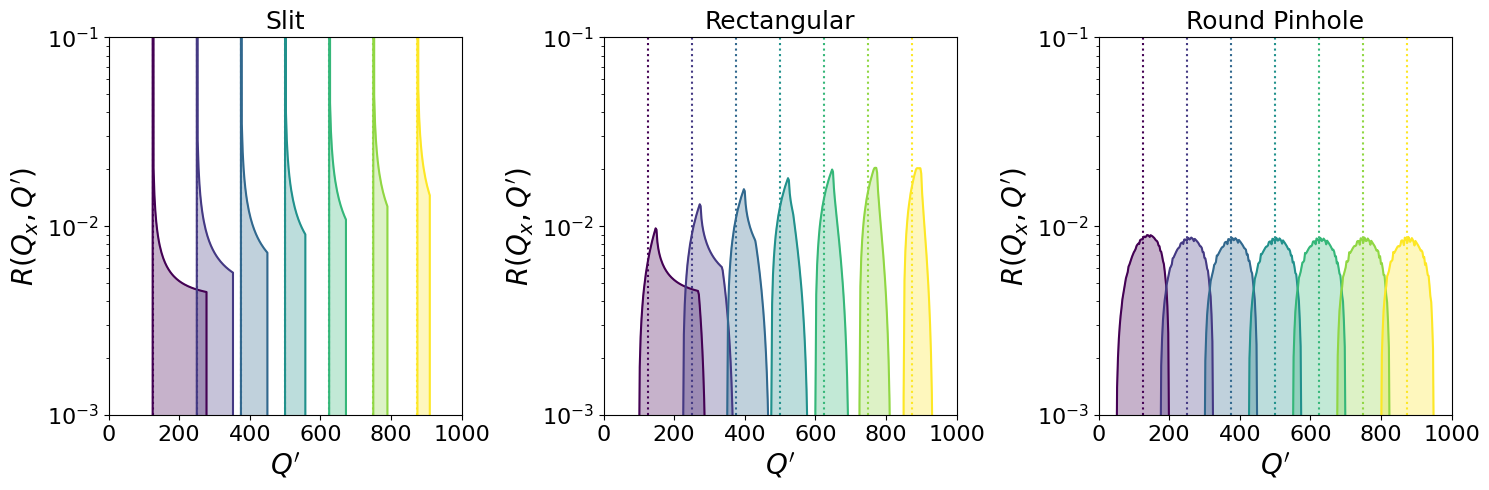

In [4]:
# --- Q ranges ---
Q_mod = np.linspace(0, 1000.0, 401)  # intrinsic Q' grid
Qx_obs = np.linspace(125, 875, 7)       # 7 observation points

# --- Instrumental widths ---
sigma_y = 250.0
sigma_x = 25.0
sigma_Q = 75.0

# --- Compute PSFs ---
Rslit  = R_slit(Qx_obs, Q_mod, sigma_y)
Rrect  = R_rect(Qx_obs, Q_mod, sigma_x, sigma_y, nx=256, quad='gauss')
Rpinh  = R_pinhole(Qx_obs, Q_mod, sigma_Q, nx=256, quad='gauss')

# --- Plot comparison ---
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Slit', 'Rectangular', 'Round Pinhole']
Rlist  = [Rslit, Rrect, Rpinh]
colors = plt.cm.viridis(np.linspace(0, 1, len(Qx_obs)))

for ax, R, title in zip(axs, Rlist, titles):
    for i, Qx in enumerate(Qx_obs):
        ax.plot(Q_mod, R[i], label=f"Qx={Qx:.0f}", color=colors[i])
        ax.fill_between(Q_mod, R[i], alpha=0.3, color=colors[i])
        ax.axvline(Qx, color=colors[i], linestyle=':')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel(r"$R(Q_x, Q^\prime)$", fontsize=20)
    ax.set_xlabel(r"$Q^\prime$", fontsize=20)
    
    ax.set_ylim(1e-3, 1e-1)
    ax.set_yscale('log')
    ax.set_xlim(0, 1000)
    ax.set_xscale('linear')
    # ax.grid(True, ls='--', alpha=0.5)
    # ax.legend(ncol=2, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
axs[-1].set_xlabel(r"$Q^\prime$")

plt.tight_layout()

# --- Check normalization (∫ R dQ' ≈ 1) ---
for name, R in zip(['slit', 'rect', 'pinhole'], Rlist):
    norm = np.trapz(R, Q_mod, axis=1)
    print(f"{name:8s} average normalization = {np.mean(norm):.6f} ± {np.std(norm):.2e}")

slit     average normalization = 5000000000000000.000000 ± 2.50e+15
rect     average normalization = 1.000000 ± 8.39e-17


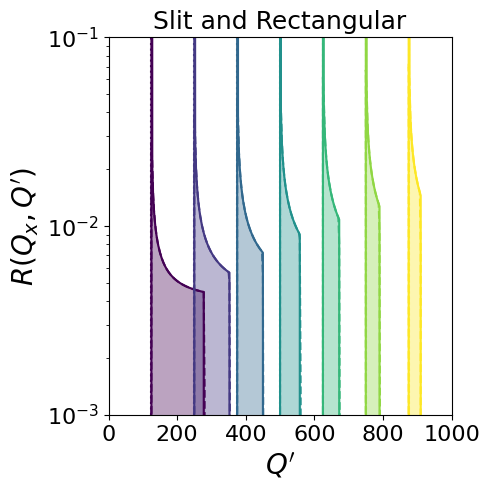

In [5]:
# --- Q ranges ---
Q_mod = np.linspace(0, 1000.0, 401)  # intrinsic Q' grid
Qx_obs = np.linspace(125, 875, 7)       # 7 observation points

# --- Instrumental widths ---
sigma_y = 250.0
sigma_x = 1

# --- Compute PSFs ---
Rslit  = R_slit(Qx_obs, Q_mod, sigma_y)
Rrect  = R_rect(Qx_obs, Q_mod, sigma_x, sigma_y, nx=256, quad='gauss')

# --- Plot comparison ---
fig, ax = plt.subplots(figsize=(5, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(Qx_obs)))

for i, Qx in enumerate(Qx_obs):
    ax.plot(Q_mod, Rslit[i], label=f"Slit Qx={Qx:.0f}", color=colors[i], linestyle='-')
    ax.plot(Q_mod, Rrect[i], label=f"Rect Qx={Qx:.0f}", color=colors[i], linestyle='--')
    ax.fill_between(Q_mod, Rslit[i], alpha=0.2, color=colors[i])
    ax.fill_between(Q_mod, Rrect[i], alpha=0.2, color=colors[i])
    ax.axvline(Qx, color=colors[i], linestyle=':')

ax.set_title('Slit and Rectangular', fontsize=18)
ax.set_ylabel(r"$R(Q_x, Q^\prime)$", fontsize=20)
ax.set_xlabel(r"$Q^\prime$", fontsize=20)
ax.set_ylim(1e-3, 1e-1)
ax.set_yscale('log')
ax.set_xlim(0, 1000)
ax.set_xscale('linear')
ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()

# --- Check normalization (∫ R dQ' ≈ 1) ---
for name, R in zip(['slit', 'rect'], [Rslit, Rrect]):
    norm = np.trapz(R, Q_mod, axis=1)
    print(f"{name:8s} average normalization = {np.mean(norm):.6f} ± {np.std(norm):.2e}")


slit     average normalization = 0.992554 ± 2.54e-02
rect     average normalization = 1.000000 ± 1.26e-16


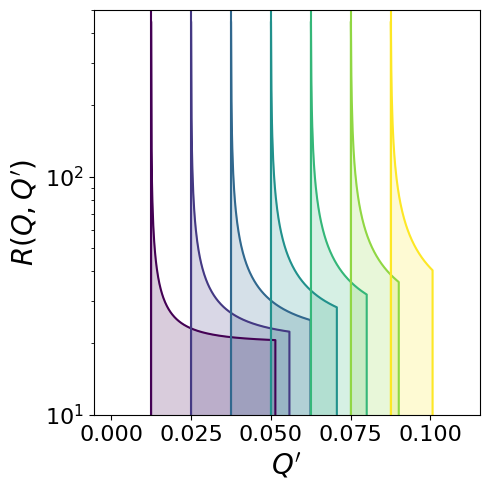

In [40]:
# --- Q ranges ---
Q_mod = np.linspace(0, 1100.0, 801)  # intrinsic Q' grid
Qx_obs = np.linspace(125, 875, 7)       # 7 observation points

# --- Instrumental widths ---
sigma_y = 0.05*10000
sigma_x = sigma_y/1e4

# --- Compute PSFs ---
Rslit  = R_slit(Qx_obs, Q_mod, sigma_y)
Rrect  = R_rect(Qx_obs, Q_mod, sigma_x, sigma_y, nx=256, quad='gauss')

# --- Plot comparison ---
fig, ax = plt.subplots(figsize=(5, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(Qx_obs)))

for i, Qx in enumerate(Qx_obs):
    ax.plot(Q_mod/10000, Rslit[i]*10000, label=f"Slit Qx={Qx:.0f}", color=colors[i], linestyle='-')
    # ax.plot(Q_mod, Rrect[i], label=f"Rect Qx={Qx:.0f}", color=colors[i], linestyle='--')
    ax.fill_between(Q_mod/10000, Rslit[i]*10000, alpha=0.2, color=colors[i])
    # ax.fill_between(Q_mod, Rrect[i], alpha=0.2, color=colors[i])
    ax.axvline(Qx/10000, color=colors[i], linestyle='-')

# ax.set_title('Slit and Rectangular', fontsize=18)
ax.set_ylabel(r"$R(Q, Q^\prime)$", fontsize=20)
ax.set_xlabel(r"$Q^\prime$", fontsize=20)
ax.set_ylim(1e1, 5e2)
ax.set_yscale('log')
# ax.set_xlim(0, 1000)
ax.set_xscale('linear')
ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()

# --- Check normalization (∫ R dQ' ≈ 1) ---
for name, R in zip(['slit', 'rect'], [Rslit, Rrect]):
    norm = np.trapz(R, Q_mod, axis=1)
    print(f"{name:8s} average normalization = {np.mean(norm):.6f} ± {np.std(norm):.2e}")


## demo geometry

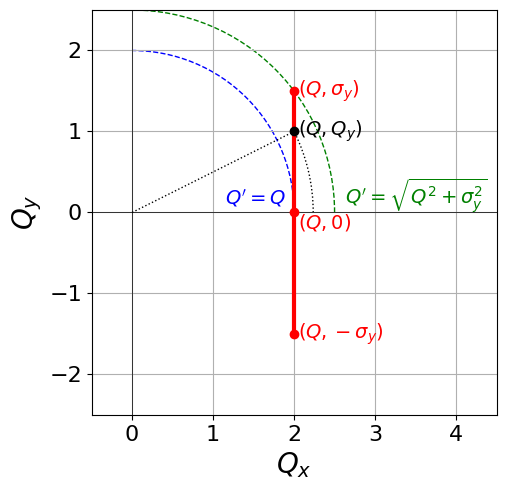

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Set parameters for the schematic
Qx_val = 2.0
sigma_y_val = 1.5
Qmax_val = np.sqrt(Qx_val**2 + sigma_y_val**2)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Draw axes
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)

# Draw the integration slit
ax.plot([Qx_val, Qx_val], [-sigma_y_val, sigma_y_val], 'r-', lw=3, label='Slit Integration Path')

# Plot points
ax.plot([Qx_val], [0], 'ro')
ax.plot([Qx_val], [sigma_y_val], 'ro')
ax.plot([Qx_val], [-sigma_y_val], 'ro')

# Add labels for points
ax.text(Qx_val + 0.05, -0.12, '$(Q, 0)$', ha='left', va='center', fontsize=14, color='r')
ax.text(Qx_val + 0.05, sigma_y_val, '$(Q, \sigma_y)$', ha='left', va='center', fontsize=14, color='r')
ax.text(Qx_val + 0.05, -sigma_y_val, '$(Q, -\sigma_y)$', ha='left', va='center', fontsize=14, color='r')

# Draw arcs to represent Q'
# Arc for Q' = Q_x
arc_min = patches.Arc((0, 0), 2 * Qx_val, 2 * Qx_val, theta1=0, theta2=90, color='blue', ls='--', label="$Q' = Q_x$ (min radius)")
ax.add_patch(arc_min)
ax.text(Qx_val / 1.75, 0.1, "$Q' = Q$", color='blue', fontsize=14)

# Arc for Q' = sqrt(Q_x^2 + sigma_y^2)
arc_max = patches.Arc((0, 0), 2 * Qmax_val, 2 * Qmax_val, theta1=0, theta2=90, color='green', ls='--', label="$Q' = \sqrt{Q_x^2 + \sigma_y^2}$ (max radius)")
ax.add_patch(arc_max)
ax.text(Qmax_val * 1.05, 0.1, "$Q' = \sqrt{Q^2 + \sigma_y^2}$", color='green', fontsize=14)

# Draw a point (Q_x, Q_y) on the slit and the corresponding arc
Qy_sample = 1.0
Q_sample = np.sqrt(Qx_val**2 + Qy_sample**2)
ax.plot([Qx_val], [Qy_sample], 'ko')
ax.text(Qx_val + 0.05, Qy_sample, '$(Q, Q_y)$', ha='left', va='center', fontsize=14)
arc_sample = patches.Arc((0, 0), 2 * Q_sample, 2 * Q_sample, theta1=0, theta2=np.degrees(np.arctan(Qy_sample/Qx_val)), color='black', ls=':', lw=1, label="$Q' = \sqrt{Q_x^2 + Q_y^2}$")
ax.add_patch(arc_sample)
ax.plot([0, Qx_val], [0, Qy_sample], 'k:', lw=1)

# Set labels and title
ax.set_xlabel('$Q_x$', fontsize=20)
ax.set_ylabel('$Q_y$', fontsize=20)

# Set limits and aspect ratio
ax.set_xlim(-0.5, Qmax_val + 2)
ax.set_ylim(-sigma_y_val - 1, sigma_y_val + 1)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

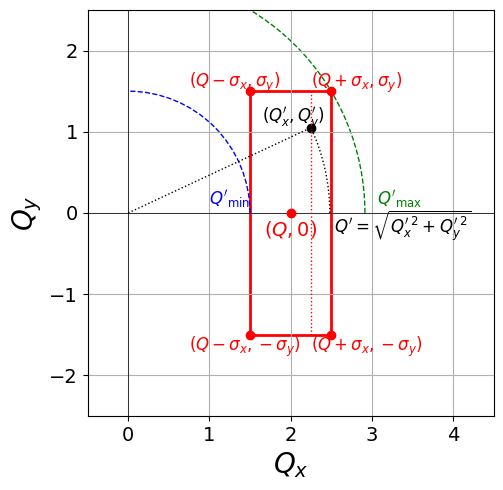

In [8]:
# Parameters
Qx_val = 2.0
sigma_x_val = 0.5
sigma_y_val = 1.5

# Approximate min/max radius contributing to I_exp(Qx):
Qmin_rect = max(Qx_val - sigma_x_val, 0.0)
Qmax_rect = np.sqrt((Qx_val + sigma_x_val)**2 + sigma_y_val**2)

# Create the plot
fig, ax = plt.subplots(figsize=(6,5))

# Axes
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)

# Draw the rectangular pinhole (average region)
rect = patches.Rectangle(
    (Qx_val - sigma_x_val, -sigma_y_val),  # bottom-left corner
    2 * sigma_x_val,                       # width
    2 * sigma_y_val,                       # height
    edgecolor='red', facecolor='none', lw=2, label='Rectangular aperture'
)
ax.add_patch(rect)

# Mark the center (Qx, 0)
ax.plot([Qx_val], [0], 'ro')
ax.text(Qx_val, -0.2, '$(Q, 0)$', ha='center', va='center', fontsize=14, color='r')

# Mark the four corners
corners = [
    (Qx_val - sigma_x_val,  sigma_y_val),
    (Qx_val + sigma_x_val,  sigma_y_val),
    (Qx_val - sigma_x_val, -sigma_y_val),
    (Qx_val + sigma_x_val, -sigma_y_val),
]
labels = [
    r'$(Q-\sigma_x, \sigma_y)$',
    r'$(Q+\sigma_x, \sigma_y)$',
    r'$(Q-\sigma_x, -\sigma_y)$',
    r'$(Q+\sigma_x, -\sigma_y)$',
]
offsets = [(-0.75, 0.1), (-0.25, 0.1), (-0.75, -0.15), (-0.25, -0.15)]
for (x, y), lab, (dx, dy) in zip(corners, labels, offsets):
    ax.plot([x], [y], 'ro')
    ax.text(x + dx, y + dy, lab, ha='left', va='center', fontsize=12, color='r')

# Arcs representing approximate Q' range
# Inner radius ~ Qx - σx
if Qmin_rect > 0:
    arc_min = patches.Arc(
        (0, 0),
        2 * Qmin_rect,
        2 * Qmin_rect,
        theta1=0,
        theta2=90,
        color='blue',
        ls='--',
        label=r"$Q'_{\min} \approx Q - \sigma_x$"
    )
    ax.add_patch(arc_min)
    ax.text(Qmin_rect / 1.5, 0.1, r"$Q'_{\min}$", color='blue', fontsize=12)

# Outer radius ~ distance to farthest corner
arc_max = patches.Arc(
    (0, 0),
    2 * Qmax_rect,
    2 * Qmax_rect,
    theta1=0,
    theta2=90,
    color='green',
    ls='--',
    label=r"$Q'_{\max}$"
)
ax.add_patch(arc_max)
ax.text(Qmax_rect * 1.05, 0.1, r"$Q'_{\max}$", color='green', fontsize=12)

# Example point (Qx', Qy') inside the rectangle
Qx_sample = Qx_val + 0.5 * sigma_x_val
Qy_sample = 0.7 * sigma_y_val
Q_sample = np.sqrt(Qx_sample**2 + Qy_sample**2)
ax.plot([Qx_sample], [Qy_sample], 'ko')
ax.text(Qx_sample - 0.6, Qy_sample+0.1, r'$(Q_x^\prime, Q_y^\prime)$', ha='left', va='center', fontsize=12)
ax.plot([Qx_sample, Qx_sample], [-sigma_y_val, sigma_y_val], 'r:', lw=1)

# Ray from origin to sample point (defines Q')
ax.plot([0, Qx_sample], [0, Qy_sample], 'k:', lw=1)
arc_sample = patches.Arc(
    (0, 0),
    2 * Q_sample,
    2 * Q_sample,
    theta1=0,
    theta2=np.degrees(np.arctan2(Qy_sample, Qx_sample)),
    color='black',
    ls=':',
    lw=1
)
ax.add_patch(arc_sample)
ax.text(Q_sample * 1.02, -0.25, r"$Q' = \sqrt{Q_x'^2 + Q_y'^2}$", fontsize=12)

# Labels and style
ax.set_xlabel('$Q_x$', fontsize=20)
ax.set_ylabel('$Q_y$', fontsize=20)
ax.set_xlim(-0.5, Qmax_val + 2)
ax.set_ylim(-sigma_y_val - 1, sigma_y_val + 1)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True)

plt.tight_layout()
plt.show()


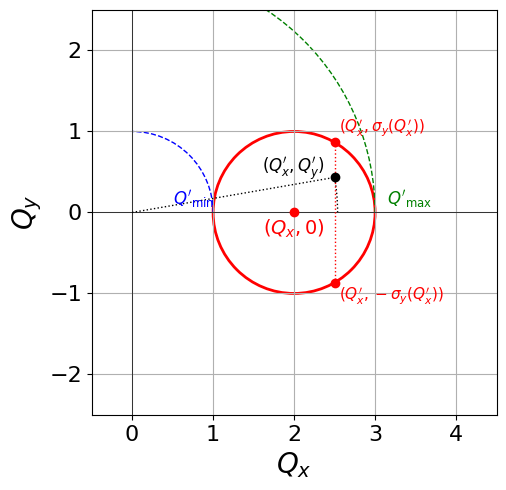

In [9]:
# Parameters
Qx_val = 2.0
sigma_Q_val = 1  # radius of circular aperture

# Approximate min/max radius contributing to I_exp(Qx):
# nearest point on the circle to the origin: max(Qx - σQ, 0)
Qmin_pinh = max(Qx_val - sigma_Q_val, 0.0)
# farthest point on the circle to the origin: Qx + σQ
Qmax_pinh = Qx_val + sigma_Q_val

# Create the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Axes
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)

# Draw the circular pinhole (average region)
circle = patches.Circle(
    (Qx_val, 0.0),         # center at (Qx, 0)
    radius=sigma_Q_val,    # radius σ_Q
    edgecolor='red',
    facecolor='none',
    lw=2,
    label='Circular aperture'
)
ax.add_patch(circle)

# Mark the center (Qx, 0)
ax.plot([Qx_val], [0], 'ro')
ax.text(Qx_val, -0.2, '$(Q_x, 0)$', ha='center', va='center', fontsize=14, color='r')

# # Mark a few key points on the circle: left, right, top, bottom
# circle_points = [
#     (Qx_val - sigma_Q_val, 0.0),
#     (Qx_val + sigma_Q_val, 0.0),
#     # (Qx_val,  sigma_Q_val),
#     # (Qx_val, -sigma_Q_val),
# ]
# labels = [
#     r'$(Q_x-\sigma_Q, 0)$',
#     r'$(Q_x+\sigma_Q, 0)$',
#     # r'$(Q_x, \sigma_Q)$',
#     # r'$(Q_x, -\sigma_Q)$',
# ]
# offsets = [
#     (-0.9, -0.2), 
#     (-0.1, -0.2), 
#     # (-0.3, 0.15), 
#     # (-0.3, -0.15)
#     ]
# for (x, y), lab, (dx, dy) in zip(circle_points, labels, offsets):
#     ax.plot([x], [y], 'ro')
#     ax.text(x + dx, y + dy, lab, ha='left', va='center', fontsize=12, color='r')

# Arcs representing approximate Q' range
# Inner radius ~ Qx - σQ
if Qmin_pinh > 0:
    arc_min = patches.Arc(
        (0, 0),
        2 * Qmin_pinh,
        2 * Qmin_pinh,
        theta1=0,
        theta2=90,
        color='blue',
        ls='--',
        label=r"$Q'_{\min} \approx Q - \sigma_Q$"
    )
    ax.add_patch(arc_min)
    ax.text(Qmin_pinh / 2, 0.1, r"$Q'_{\min}$", color='blue', fontsize=12)

# Outer radius ~ Qx + σQ
arc_max = patches.Arc(
    (0, 0),
    2 * Qmax_pinh,
    2 * Qmax_pinh,
    theta1=0,
    theta2=90,
    color='green',
    ls='--',
    label=r"$Q'_{\max} \approx Q + \sigma_Q$"
)
ax.add_patch(arc_max)
ax.text(Qmax_pinh * 1.05, 0.1, r"$Q'_{\max}$", color='green', fontsize=12)

# Example horizontal position Qx' inside the aperture
Qx_prime = Qx_val + 0.5 * sigma_Q_val     # choose inside the circle
sigma_y_prime = np.sqrt(max(sigma_Q_val**2 - (Qx_prime - Qx_val)**2, 0.0))

# Draw the local slit at Qx' with height 2 σ_y(Qx')
ax.plot([Qx_prime, Qx_prime], [-sigma_y_prime, sigma_y_prime],
        'r:', lw=1)
ax.plot([Qx_prime], [sigma_y_prime], 'ro')
ax.plot([Qx_prime], [-sigma_y_prime], 'ro')

# ax.text(Qx_prime - 0.9, 0.0,
#         r'$(Q_x^\prime, 0)$', ha='left', va='center', fontsize=12)
ax.text(Qx_prime + 0.05, sigma_y_prime*1.2,
        r'$(Q_x^\prime, \sigma_y(Q_x^\prime))$',
        ha='left', va='center', fontsize=11, color='r')
ax.text(Qx_prime + 0.05, -sigma_y_prime*1.2,
        r'$(Q_x^\prime, -\sigma_y(Q_x^\prime))$',
        ha='left', va='center', fontsize=11, color='r')

# Example point (Qx', Qy') on that local slit
Qy_sample = 0.5 * sigma_y_prime
Q_sample = np.sqrt(Qx_prime**2 + Qy_sample**2)
ax.plot([Qx_prime], [Qy_sample], 'ko')
ax.text(Qx_prime - 0.9, Qy_sample + 0.1,
        r'$(Q_x^\prime, Q_y^\prime)$', ha='left', va='center', fontsize=12)

# Ray from origin to sample point (defines Q')
ax.plot([0, Qx_prime], [0, Qy_sample], 'k:', lw=1)
arc_sample = patches.Arc(
    (0, 0),
    2 * Q_sample,
    2 * Q_sample,
    theta1=0,
    theta2=np.degrees(np.arctan2(Qy_sample, Qx_prime)),
    color='black',
    ls=':',
    lw=1
)
ax.add_patch(arc_sample)
# ax.text(Q_sample * 1.02, -0.25,
#         r"$Q' = \sqrt{Q_x'^2 + Q_y'^2}$", fontsize=12)

# Labels and style
ax.set_xlabel('$Q_x$', fontsize=20)
ax.set_ylabel('$Q_y$', fontsize=20)
ax.set_xlim(-0.5, Qmax_val + 2)
ax.set_ylim(-sigma_y_val - 1, sigma_y_val + 1)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(True)

plt.tight_layout()
plt.show()


## test smearing a given function

In [10]:
def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

def P_ts(Q, q_max, c):
    Qq = Q/q_max
    P = 1/((1-c)*((1-Qq**2)**2)+c)
    P[Qq==0] = 1
    return P

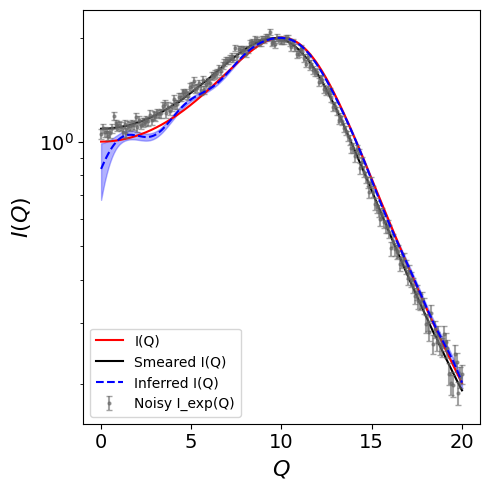

In [11]:
# f_Q = lambda Q: P_hs(Q) + 0.001
f_Q = lambda Q: P_ts(Q, 10, 0.5) + 0.001

# f_R = lambda Q1, Q2: R_slit(Q1, Q2, sigma_y=5)
f_R = lambda Q1, Q2: R_rect(Q1, Q2, sigma_x=1e-7, sigma_y=5, nx=256, quad='gauss')

Q_min = 1e-2
Q_max = 20
Q_sampled = np.linspace(Q_min, Q_max, 200)          # experimental Q
Q_model   = np.linspace(Q_min/2, Q_max*2, 40001)    # fine latent Q

I_model = f_Q(Q_model)

# --- Forward smearing operator: R_mat (normalized and weighted) ---
R_raw = f_R(Q_sampled, Q_model)               # shape (N_obs, N_lat)

# trapezoidal integration weights on Q_model
w = np.zeros_like(Q_model)
w[1:-1] = 0.5 * (Q_model[2:] - Q_model[:-2])
w[0]    = 0.5 * (Q_model[1] - Q_model[0])
w[-1]   = 0.5 * (Q_model[-1] - Q_model[-2])

# weighted kernel (discrete numerator of ∫ R I dQ')
num = R_raw * w[None, :]                            # (N_obs, N_lat)

# normalize rows so each PSF integrates to 1
row_sum = num.sum(axis=1, keepdims=True)            # (N_obs, 1)
R_mat = num / row_sum                               # (N_obs, N_lat)

# forward model: smeared intensity
I_smeared = R_mat @ I_model

# --- Add Poisson noise ---
c_I = 1000                                      # counts per I unit
I_noise = np.random.poisson(I_smeared * c_I) / c_I - I_smeared
I_exp   = I_smeared + I_noise
Delta_I = np.sqrt(I_smeared * c_I) / c_I           # counting error

# =======================
#        GPR inversion
# =======================

# GP prior on the *unsmeared* intensity at Q_sampled
lmbda = 2
K_sample = np.exp(-(Q_sampled[:, None] - Q_sampled[None, :])**2 / (2 * lmbda**2))

# --- Build smearing operator R_sample on experimental grid ---

# raw slit kernel on (Q_obs, Q_latent) = (Q_sampled, Q_sampled)
R_raw_sample = f_R(Q_sampled, Q_sampled)       # shape (N, N)

# trapezoidal weights on the integration variable Q' = Q_sampled
w_s = np.zeros_like(Q_sampled)
w_s[1:-1] = 0.5 * (Q_sampled[2:] - Q_sampled[:-2])
w_s[0]    = 0.5 * (Q_sampled[1] - Q_sampled[0])
w_s[-1]   = 0.5 * (Q_sampled[-1] - Q_sampled[-2])

# discrete approximation of the smearing integral
# y_i ≈ sum_j R_raw(Q_i, Q_j) * f_j * w_j
R_sample = R_raw_sample * w_s[None, :]               # (N_obs, N_latent) = (N, N)

# I_sampled_forward = R_sample @ I_smeared    # forward model on sampled grid (for verification)

# f_Q = lambda Q: P_hs(Q) + 0.001
f_Q = lambda Q: P_ts(Q, 10, 0.5) + 0.001

f_R = lambda Q1, Q2: R_slit(Q1, Q2, sigma_y=5)
# f_R = lambda Q1, Q2: R_rect(Q1, Q2, sigma_x=1e-7, sigma_y=5, nx=256, quad='gauss')

Q_min = 1e-2
Q_max = 20
Q_sampled = np.linspace(Q_min, Q_max, 200)          # experimental Q
Q_model   = np.linspace(Q_min/2, Q_max*2, 40001)    # fine latent Q

I_model = f_Q(Q_model)

# --- Forward smearing operator: R_mat (normalized and weighted) ---
R_raw = f_R(Q_sampled, Q_model)               # shape (N_obs, N_lat)

# trapezoidal integration weights on Q_model
w = np.zeros_like(Q_model)
w[1:-1] = 0.5 * (Q_model[2:] - Q_model[:-2])
w[0]    = 0.5 * (Q_model[1] - Q_model[0])
w[-1]   = 0.5 * (Q_model[-1] - Q_model[-2])

# weighted kernel (discrete numerator of ∫ R I dQ')
num = R_raw * w[None, :]                            # (N_obs, N_lat)

# normalize rows so each PSF integrates to 1
row_sum = num.sum(axis=1, keepdims=True)            # (N_obs, 1)
R_mat = num / row_sum                               # (N_obs, N_lat)

# forward model: smeared intensity
I_smeared = R_mat @ I_model

# --- Add Poisson noise ---
c_I = 1000                                      # counts per I unit
I_noise = np.random.poisson(I_smeared * c_I) / c_I - I_smeared
I_exp   = I_smeared + I_noise
Delta_I = np.sqrt(I_smeared * c_I) / c_I           # counting error

# =======================
#        GPR inversion
# =======================

# GP prior on the *unsmeared* intensity at Q_sampled
lmbda = 2
K_sample = np.exp(-(Q_sampled[:, None] - Q_sampled[None, :])**2 / (2 * lmbda**2))

# --- Build smearing operator R_sample on experimental grid ---

# raw slit kernel on (Q_obs, Q_latent) = (Q_sampled, Q_sampled)
# this may contain inf on the diagonal for R_slit
R_raw_sample = f_R(Q_sampled, Q_sampled)       # shape (N, N)
N = Q_sampled.size

# trapezoidal weights on the integration variable Q' = Q_sampled
w_s = np.zeros_like(Q_sampled)
w_s[1:-1] = 0.5 * (Q_sampled[2:] - Q_sampled[:-2])
w_s[0]    = 0.5 * (Q_sampled[1] - Q_sampled[0])
w_s[-1]   = 0.5 * (Q_sampled[-1] - Q_sampled[-2])

# ---- reconstruct the diagonal from the integral constraint ----
# We want:  sum_j R_ij * w_j  ≈  1  for each row i
R_fix = R_raw_sample.copy()

# zero out diagonal (removes inf and excludes it from the off-diagonal sum)
np.fill_diagonal(R_fix, 0.0)

# off-diagonal contribution to the integral in each row: sum_{j≠i} R_ij * w_j
row_sum_off = R_fix @ w_s   # shape (N,)

target = 1.0  # analytic integral of each slit PSF row ∫ R_slit(Q_i, Q') dQ' = 1
diag_vals = (target - row_sum_off) / w_s        # shape (N,)

# put reconstructed diagonal back
R_fix[np.arange(N), np.arange(N)] = diag_vals

# discrete approximation of the smearing integral:
# y_i ≈ sum_j R_fix(Q_i, Q_j) * f_j * w_j
R_sample = R_fix * w_s[None, :]                 # (N_obs, N_latent) = (N, N)

I_sampled_forward = R_sample @ I_smeared    # forward model on sampled grid (for verification)

# ---------- GPR ----------
# ---------- PRIOR MEAN ----------
# define your prior mean on the same grid Q_sampled
I_prior = np.ones_like(Q_sampled)   # <-- you provide this function / array

# ---------- GP LINEAR-OPERATOR POSTERIOR WITH PRIOR MEAN ----------

Sigma = np.diag(Delta_I**2)
Ky    = K_sample @ R_sample.T
Kyy   = R_sample @ K_sample @ R_sample.T + Sigma

# posterior mean:  E[f | y] = m + Ky Kyy^{-1} (y - R m)
residual = I_exp - (R_sample @ I_prior)
I_post   = I_prior + Ky @ np.linalg.solve(Kyy, residual)

# posterior covariance: Cov(f | y)
Kyy_inv = np.linalg.solve(Kyy, np.eye(N))
Cov_f   = K_sample - Ky @ Kyy_inv @ Ky.T

I_post_std = np.sqrt(np.diag(Cov_f))

# =======================
#        Plot
# =======================

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

mask = (Q_model >= Q_min) & (Q_model <= Q_max)

ax.plot(Q_model[mask], I_model[mask],
        label='I(Q)', color='red')

ax.plot(Q_sampled, I_smeared,
        label='Smeared I(Q)', color='k', linestyle='-')

# ax.plot(Q_sampled, I_exp,
#         label='Noisy I_exp(Q)', color='green', linestyle='', marker='.', markersize=4, alpha=0.6)
ax.errorbar(Q_sampled, I_exp, yerr=Delta_I,
            label='Noisy I_exp(Q)', color='#666666', linestyle='', marker='.', markersize=4, alpha=0.6, capsize=2)

ax.plot(Q_sampled, I_post,
        label='Inferred I(Q)', color='blue', linestyle='--', zorder=10)

# ax.plot(Q_sampled, I_sampled_forward,
#         label='Forward R I_smeared(Q)', color='purple', linestyle=':')

ax.fill_between(Q_sampled,
                I_post - I_post_std,
                I_post + I_post_std,
                color='blue', alpha=0.3)

ax.set_yscale('log')
ax.set_xlabel(r"$Q$", fontsize=16)
ax.set_ylabel(r"$I(Q)$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=10)
plt.tight_layout()

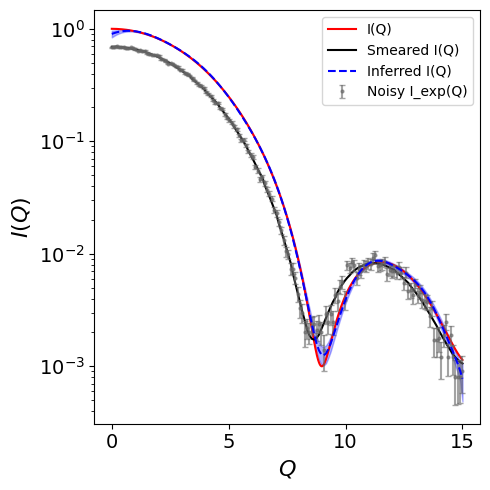

In [12]:
f_Q = lambda Q: P_hs(Q) + 0.001
# f_Q = lambda Q: P_ts(Q, 10, 0.5) + 0.001

f_R = lambda Q1, Q2: R_slit(Q1, Q2, sigma_y=5)
# f_R = lambda Q1, Q2: R_rect(Q1, Q2, sigma_x=1e-7, sigma_y=5, nx=256, quad='gauss')

Q_min = 1e-2
Q_max = 15
Q_sampled = np.linspace(Q_min, Q_max, 150)          # experimental Q
Q_model   = np.linspace(Q_min/2, Q_max*2, 40001)    # fine latent Q

I_model = f_Q(Q_model)

# --- Forward smearing operator: R_mat (normalized and weighted) ---
R_raw = f_R(Q_sampled, Q_model)               # shape (N_obs, N_lat)

# trapezoidal integration weights on Q_model
w = np.zeros_like(Q_model)
w[1:-1] = 0.5 * (Q_model[2:] - Q_model[:-2])
w[0]    = 0.5 * (Q_model[1] - Q_model[0])
w[-1]   = 0.5 * (Q_model[-1] - Q_model[-2])

# weighted kernel (discrete numerator of ∫ R I dQ')
num = R_raw * w[None, :]                            # (N_obs, N_lat)

# normalize rows so each PSF integrates to 1
row_sum = num.sum(axis=1, keepdims=True)            # (N_obs, 1)
R_mat = num / row_sum                               # (N_obs, N_lat)

# forward model: smeared intensity
I_smeared = R_mat @ I_model

# --- Add Poisson noise ---
c_I = 10000                                      # counts per I unit
I_noise = np.random.poisson(I_smeared * c_I) / c_I - I_smeared
I_exp   = I_smeared + I_noise
Delta_I = np.sqrt(I_smeared * c_I) / c_I           # counting error

# =======================
#        GPR inversion
# =======================

# GP prior on the *unsmeared* intensity at Q_sampled
lmbda = 2
K_sample = np.exp(-(Q_sampled[:, None] - Q_sampled[None, :])**2 / (2 * lmbda**2))

# --- Build smearing operator R_sample on experimental grid ---

# raw slit kernel on (Q_obs, Q_latent) = (Q_sampled, Q_sampled)
# this may contain inf on the diagonal for R_slit
R_raw_sample = f_R(Q_sampled, Q_sampled)       # shape (N, N)
N = Q_sampled.size

# trapezoidal weights on the integration variable Q' = Q_sampled
w_s = np.zeros_like(Q_sampled)
w_s[1:-1] = 0.5 * (Q_sampled[2:] - Q_sampled[:-2])
w_s[0]    = 0.5 * (Q_sampled[1] - Q_sampled[0])
w_s[-1]   = 0.5 * (Q_sampled[-1] - Q_sampled[-2])

# ---- reconstruct the diagonal from the integral constraint ----
# We want:  sum_j R_ij * w_j  ≈  1  for each row i
R_fix = R_raw_sample.copy()

# zero out diagonal (removes inf and excludes it from the off-diagonal sum)
np.fill_diagonal(R_fix, 0.0)

# off-diagonal contribution to the integral in each row: sum_{j≠i} R_ij * w_j
row_sum_off = R_fix @ w_s   # shape (N,)

target = 1.0  # analytic integral of each slit PSF row ∫ R_slit(Q_i, Q') dQ' = 1
diag_vals = (target - row_sum_off) / w_s        # shape (N,)

# put reconstructed diagonal back
R_fix[np.arange(N), np.arange(N)] = diag_vals

# discrete approximation of the smearing integral:
# y_i ≈ sum_j R_fix(Q_i, Q_j) * f_j * w_j
R_sample = R_fix * w_s[None, :]                 # (N_obs, N_latent) = (N, N)

I_sampled_forward = R_sample @ I_smeared    # forward model on sampled grid (for verification)

# ---------- GPR ----------
# ---------- PRIOR MEAN ----------
# define your prior mean on the same grid Q_sampled
# I_prior = np.ones_like(Q_sampled)   # <-- you provide this function / array
# I_prior = I_sampled_forward
from scipy.ndimage import gaussian_filter1d
I_prior = gaussian_filter1d(I_smeared, sigma=5)

# ---------- GP LINEAR-OPERATOR POSTERIOR WITH PRIOR MEAN ----------

Sigma = np.diag(Delta_I**2)
Ky    = K_sample @ R_sample.T
Kyy   = R_sample @ K_sample @ R_sample.T + Sigma

# posterior mean:  E[f | y] = m + Ky Kyy^{-1} (y - R m)
residual = I_exp - (R_sample @ I_prior)
I_post   = I_prior + Ky @ np.linalg.solve(Kyy, residual)

# posterior covariance: Cov(f | y)
Kyy_inv = np.linalg.solve(Kyy, np.eye(N))
Cov_f   = K_sample - Ky @ Kyy_inv @ Ky.T

I_post_std = np.sqrt(np.diag(Cov_f))

# =======================
#        Plot
# =======================

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

mask = (Q_model >= Q_min) & (Q_model <= Q_max)

ax.plot(Q_model[mask], I_model[mask],
        label='I(Q)', color='red')

ax.plot(Q_sampled, I_smeared,
        label='Smeared I(Q)', color='k', linestyle='-')

# ax.plot(Q_sampled, I_exp,
#         label='Noisy I_exp(Q)', color='green', linestyle='', marker='.', markersize=4, alpha=0.6)
ax.errorbar(Q_sampled, I_exp, yerr=Delta_I,
            label='Noisy I_exp(Q)', color='#666666', linestyle='', marker='.', markersize=4, alpha=0.6, capsize=2)

ax.plot(Q_sampled, I_post,
        label='Inferred I(Q)', color='blue', linestyle='--', zorder=10)

# ax.plot(Q_sampled, I_sampled_forward,
#         label='Forward R I_smeared(Q)', color='purple', linestyle=':')

ax.fill_between(Q_sampled,
                I_post - I_post_std,
                I_post + I_post_std,
                color='blue', alpha=0.3)

ax.set_yscale('log')
ax.set_xlabel(r"$Q$", fontsize=16)
ax.set_ylabel(r"$I(Q)$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=10)
plt.tight_layout()


In [13]:
f_Q = lambda Q: P_hs(Q*5e3) + 0.0001
# f_Q = lambda Q: P_ts(Q, 10, 0.5) + 0.001
# f_Q = lambda Q: S_rod(Q, 2e4)

# f_R = lambda Q1, Q2: R_slit(Q1, Q2, sigma_y=0.1)
f_R = lambda Q1, Q2: R_rect(Q1, Q2, sigma_x=1e-4, sigma_y=0.1, nx=64, quad='gauss')

Q_min = 5e-5
Q_max = 0.1
# Q_sampled = np.linspace(Q_min, Q_max, 200)          # experimental Q
Q_sampled = np.logspace(np.log10(Q_min), np.log10(Q_max), 200)  # experimental Q
# Q_model   = np.linspace(Q_min/2, Q_max*2, 40001)    # fine latent Q
Q_model = np.logspace(np.log10(Q_min/2), np.log10(Q_max*2), 32768)

I_model = f_Q(Q_model)
I_max = I_model[(Q_model < Q_max)&(Q_model > Q_min)].max()
I_min = I_model[(Q_model < Q_max)&(Q_model > Q_min)].min()

# --- Forward smearing operator: R_mat (normalized and weighted) ---
R_raw = f_R(Q_sampled, Q_model)               # shape (N_obs, N_lat)

# trapezoidal integration weights on Q_model
w = np.zeros_like(Q_model)
w[1:-1] = 0.5 * (Q_model[2:] - Q_model[:-2])
w[0]    = 0.5 * (Q_model[1] - Q_model[0])
w[-1]   = 0.5 * (Q_model[-1] - Q_model[-2])

# weighted kernel (discrete numerator of ∫ R I dQ')
num = R_raw * w[None, :]                            # (N_obs, N_lat)

# normalize rows so each PSF integrates to 1
row_sum = num.sum(axis=1, keepdims=True)            # (N_obs, 1)
R_mat = num / row_sum                               # (N_obs, N_lat)

# forward model: smeared intensity
I_smeared = R_mat @ I_model

# --- Add Poisson noise ---
c_I = 1e6                                      # counts per I unit
rng = np.random.default_rng()
I_exp = rng.poisson(I_smeared * c_I ) / c_I
Delta_I = np.sqrt(I_smeared * c_I) / c_I           # counting error

# --- Build smearing operator R_sample on experimental grid ---

# raw slit kernel on (Q_obs, Q_latent) = (Q_sampled, Q_sampled)
# this may contain inf on the diagonal for R_slit
R_raw_sample = f_R(Q_sampled, Q_sampled)       # shape (N, N)
N = Q_sampled.size

# trapezoidal weights on the integration variable Q' = Q_sampled
w_s = np.zeros_like(Q_sampled)
w_s[1:-1] = 0.5 * (Q_sampled[2:] - Q_sampled[:-2])
w_s[0]    = 0.5 * (Q_sampled[1] - Q_sampled[0])
w_s[-1]   = 0.5 * (Q_sampled[-1] - Q_sampled[-2])

# ---- reconstruct the diagonal from the integral constraint ----
# We want:  sum_j R_ij * w_j  ≈  1  for each row i
R_fix = R_raw_sample.copy()

# # zero out diagonal (removes inf and excludes it from the off-diagonal sum)
# np.fill_diagonal(R_fix, 0.0)

# # off-diagonal contribution to the integral in each row: sum_{j≠i} R_ij * w_j
# row_sum_off = R_fix @ w_s   # shape (N,)

# target = 1.0  # analytic integral of each slit PSF row ∫ R_slit(Q_i, Q') dQ' = 1
# diag_vals = (target - row_sum_off) / w_s        # shape (N,)

# # put reconstructed diagonal back
# R_fix[np.arange(N), np.arange(N)] = diag_vals

# discrete approximation of the smearing integral:
# y_i ≈ sum_j R_fix(Q_i, Q_j) * f_j * w_j
R_sample = R_fix * w_s[None, :]                 # (N_obs, N_latent) = (N, N)

I_sampled_forward = R_sample @ I_smeared    # forward model on sampled grid (for verification)

# =======================
#        GPR inversion
# =======================
# GP prior on the *unsmeared* intensity at Q_sampled
# lmbda = 2e-3
lmbda = np.log(Q_max / Q_min)/Q_sampled.size*25   # correlation length
# K_sample = np.exp(-(Q_sampled[:, None] - Q_sampled[None, :])**2 / (2 * lmbda**2))
K_sample = np.exp(-(np.log(Q_sampled[:, None]) - np.log(Q_sampled[None, :]))**2 / (2 * lmbda**2))

# ---------- PRIOR MEAN ----------
# define your prior mean on the same grid Q_sampled
# I_prior = np.ones_like(Q_sampled)   # <-- you provide this function / array
# I_prior = I_sampled_forward
from scipy.ndimage import gaussian_filter1d
I_prior = gaussian_filter1d(I_smeared, sigma=15)
I_prior_ratio = (np.log(I_prior)-np.log(I_prior.min()))/(np.log(I_prior.max())-np.log(I_prior.min()))
I_prior = I_min * (I_max/I_min)**I_prior_ratio

# ---------- GP LINEAR-OPERATOR POSTERIOR WITH PRIOR MEAN ----------

Sigma = np.diag(Delta_I**2)
Ky    = K_sample @ R_sample.T
Kyy   = R_sample @ K_sample @ R_sample.T + Sigma

# posterior mean:  E[f | y] = m + Ky Kyy^{-1} (y - R m)
residual = I_exp - (R_sample @ I_prior)
I_post   = I_prior + Ky @ np.linalg.solve(Kyy, residual)

# posterior covariance: Cov(f | y)
Kyy_inv = np.linalg.solve(Kyy, np.eye(N))
Cov_f   = K_sample - Ky @ Kyy_inv @ Ky.T

I_post_std = np.sqrt(np.diag(Cov_f))


/tmp/ipykernel_4185292/2008896605.py:111: RuntimeWarning: invalid value encountered in sqrt
  I_post_std = np.sqrt(np.diag(Cov_f))


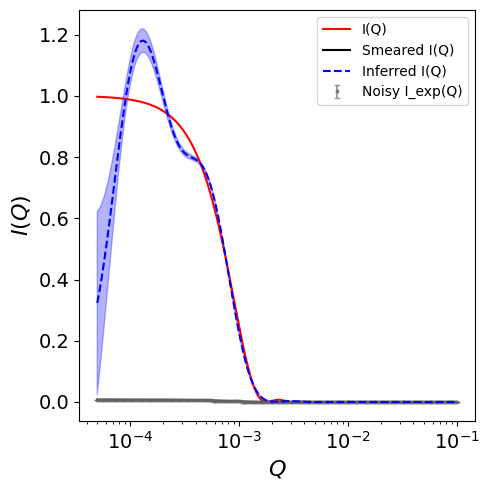

In [14]:

# =======================
#        Plot
# =======================

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

mask = (Q_model >= Q_min) & (Q_model <= Q_max)

ax.plot(Q_model[mask], I_model[mask],
        label='I(Q)', color='red')

ax.plot(Q_sampled, I_smeared,
        label='Smeared I(Q)', color='k', linestyle='-')

ax.errorbar(Q_sampled, I_exp, yerr=Delta_I,
            label='Noisy I_exp(Q)', color='#666666', linestyle='', marker='.', markersize=4, alpha=0.6, capsize=2)

# ax.plot(Q_sampled, I_sampled_forward,
#         label='Forward R I_smeared(Q)', color='purple', linestyle=':')

ax.plot(Q_sampled, I_post,
        label='Inferred I(Q)', color='blue', linestyle='--', zorder=10)

ax.fill_between(Q_sampled,
                I_post - I_post_std,
                I_post + I_post_std,
                color='blue', alpha=0.3)

# ax.plot(Q_sampled, I_prior,
#         label='Prior Mean I(Q)', color='green', linestyle=':')

# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$Q$", fontsize=16)
ax.set_ylabel(r"$I(Q)$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=10)
plt.tight_layout()


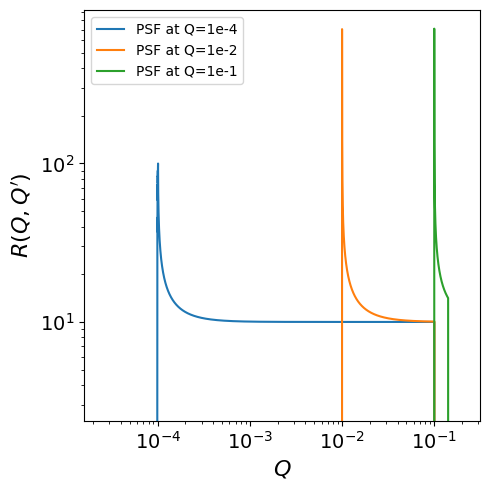

In [15]:
f_R = lambda Q1, Q2: R_rect(Q1, Q2, sigma_x=1e-6, sigma_y=0.1, nx=64, quad='gauss')
# =======================
#        Plot
# =======================

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

mask = (Q_model >= Q_min) & (Q_model <= Q_max)

psf_1 = f_R([1e-4], Q_model)
ax.plot(Q_model, psf_1[0], label='PSF at Q=1e-4')

psf2 = f_R([1e-2], Q_model)
ax.plot(Q_model, psf2[0], label='PSF at Q=1e-2')

psf3 = f_R([1e-1], Q_model)
ax.plot(Q_model, psf3[0], label='PSF at Q=1e-1')


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$Q$", fontsize=16)
ax.set_ylabel(r"$R(Q, Q')$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=10)
plt.tight_layout()
